In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression, build_resnet
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pickle as pkl
import json

from MobiusAPI.http_post_get import mobius_post, mobius_get

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

2023-10-17 02:33:21.026298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:33:21.181904: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 02:33:21.228272: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 02:33:21.822583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def heatmap(matrix, title, label):
    save_path = 'plot/cm.png'
    df=pd.DataFrame(matrix, index = label, columns = label)
    plt.figure(figsize=(10,10))
    sns.heatmap(df, annot=True, fmt = 'd')
    plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Prediction",position = (0.5,1.0+0.05))
    plt.ylabel("Ground Truth")
    plt.title(title)
    plt.savefig(save_path, format='png', dpi=300)

In [3]:
def train_dnn(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_dnn_reg(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    Y_pred_label = y_pred
    Y_gt_label = np.argmax(y_gt, axis = 1)
    cm = confusion_matrix(Y_gt_label, Y_pred_label)
    label = [str(i) for i in range(17)]
    heatmap(cm, 'Counting', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')


    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [4]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [5]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            tmp = file.split('_')
            tmp[0] = tmp[0].zfill(2)
            createFolder('./'+path+'/' + tmp[0])
            shutil.move('./'+path+'/' + file, './'+path+'/' + tmp[0] + '/' + file)

In [6]:
def file_load(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            # print(file_path)
            temp = np.load(file_path)
            if data is not None:
                data = np.concatenate((data, temp), axis = 0)
            else:
                data = temp
            # data.append(temp)
    return np.squeeze(data, axis = 1)

In [7]:
def file_load_split(folder_path, folder_list, minmax, initial_data = None):
    train_dict = dict()
    test_dict = dict()
    for folder in folder_list:
        temp_path = os.path.join(folder_path,folder)
        file_list = os.listdir(temp_path)
        for file in file_list:
            temp_file = file.split('_')
            file_path = os.path.join(temp_path, file)
            if os.path.isfile(file_path):
                # print(file_path)
                temp = np.squeeze(np.load(file_path), axis = 1)
                # temp = minmax.transform(np.squeeze(np.load(file_path), axis = 1))
                if initial_data is not None:
                    temp = np.subtract(temp, initial_data)
                temp = minmax.transform(temp)
                if temp_file[1] == '5' or temp_file[1] == '4':
                    test_dict = make_arr(test_dict, folder, temp)
                else:
                    train_dict = make_arr(train_dict, folder, temp)
    return train_dict, test_dict

def make_arr(dict, key, data):
    if key in dict.keys():
        dict[key] = np.concatenate((dict[key], data), axis = 0)
    else:
        dict[key] = data
    return dict

In [8]:
folder_path = 'counting_cylinder'
# folder_path = 'counting_disk'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [9]:
file_sort(folder_path)

In [10]:
folder_list = os.listdir(folder_path)

In [11]:
folder_list = sorted(folder_list)

In [12]:
data_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    data_dict[folder] = np.expand_dims(np.array(file_load(temp_path)), axis = 2)
reshaped_data = data_dict

In [15]:
data_dict['00'].shape

(940, 301, 1)

In [14]:
initial_data = np.expand_dims(np.mean(data_dict['00'], axis = 0), axis = 0)
initial_data_path = './initial_data.json'
with open(initial_data_path, 'w') as outfile:
    json.dump(initial_data.tolist(), outfile)
# reshaped_data = data_dict
reshaped_data = dict()
for i in data_dict.keys():
    reshaped_data[i] = np.subtract(data_dict[i], initial_data)

In [16]:
reshaped_data = data_dict
total_reshaped_data = [data for i in reshaped_data.keys() for data in reshaped_data[i]]
total_reshaped_data = np.array(total_reshaped_data)
total_reshaped_data.shape

minmax = MinMaxScaler()
minmax.fit(total_reshaped_data)
total_reshaped_data = minmax.transform(total_reshaped_data)
# scaler = StandardScaler()
# total_reshaped_data = scaler.fit_transform(total_reshaped_data)
# scaled_total_reshaped_data = scaler.transform(total_reshaped_data)
pca = PCA()
pca.fit(total_reshaped_data)

PCA()

In [17]:
pkl.dump(minmax, open('./preprocessed/minmax_denoised.pkl', 'wb'))
# pkl.dump(scaler, open('./preprocessed/scaler.pkl', 'wb'))
pkl.dump(pca, open('./preprocessed/pca.pkl', 'wb'))

In [19]:
range_fft_dict= dict()
for i in reshaped_data.keys():
    range_fft_dict[i] = np.fft.fftshift(np.fft.fft(reshaped_data[i], axis=1), axes=1)
    # range_fft_dict[i] = np.fft.fft(reshaped_data[i], axis=1)

In [20]:
reshaped_data['00'].shape

(20, 301)

In [21]:
def preprocessed(
        data, 
        # scaler, 
        minmax,
        pca
        ):
    # data = np.squeeze(data, axis = 1)
    data = minmax.transform(data)
    # data = scaler.transform(data)
    # data = pca.transform(data)
    # data = np.expand_dims(data, axis = 1)
    return data


# x = np.linspace(400, 1150, 301)
for i in reshaped_data.keys():
    # reshaped_data[i] = preprocessed(reshaped_data[i], scaler, pca)
    reshaped_data[i] = preprocessed(reshaped_data[i], minmax, pca)

In [22]:
train_dict, test_dict = file_load_split(folder_path, folder_list, minmax, initial_data)

In [23]:
# 서브플롯 그리기
num_profiles = len(range_fft_dict)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(10 * np.log10(np.abs(profile)), aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [65]:
# # 그래프 그리기
# num_profiles = len(range_fft_dict)

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     Z = 10 * np.log10(np.abs(profile))
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [66]:
# num_profiles = len(reshaped_data)

# for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     # Z = 10 * np.log10(np.abs(profile))
#     Z = np.abs(profile)
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# 서브플롯 그리기 Train data
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(train_dict.items(), 1):
# for idx, (key, profile) in enumerate(data_dict.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [ ]:
# 서브플롯 그리기 Test data
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(test_dict.items(), 1):
# for idx, (key, profile) in enumerate(data_dict.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

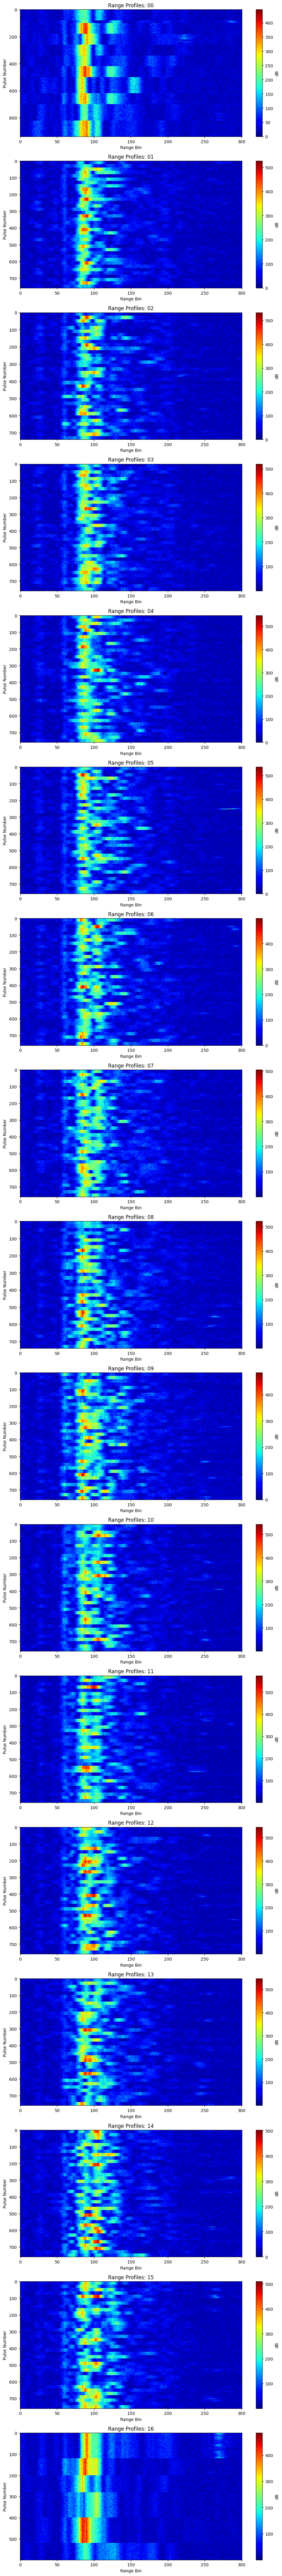

In [17]:
# 서브플롯 그리기 Total data
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
# for idx, (key, profile) in enumerate(data_dict.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [24]:
# model = basemodel(len(range_fft_dict))

In [134]:
from sklearn.utils import shuffle

def make_dataset_split(train_dict, test_dict):
    # x = list()
    
    def make_label(dict):
        y = list()
        x = None
        for key, data in train_dict.items():
            if x is None:
                x = data
            else:
                x = np.concatenate((x, data), axis = 0)
            for i in range(data.shape[0]):
                y.append(to_categorical(int(key), num_classes=len(data_dict)))
        y = np.array(y)
        return x, y
    X_train, Y_train = make_label(train_dict)
    X_test, Y_test = make_label(test_dict)
    X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
    X_test, Y_test = shuffle(X_test, Y_test, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [135]:
X_train, X_test, Y_train, Y_test = make_dataset_split(train_dict, test_dict)
X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

In [13]:
def make_dataset(data_dict):
    # x = list()
    y = list()
    x = None
    for key, data in data_dict.items():
        if x is None:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
        for i in range(data.shape[0]):
            one_hot = to_categorical(int(key), num_classes=len(data_dict))
            y.append(one_hot)
    print(x.shape)
    y = np.array(y)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [18]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
X_train, X_test, Y_train, Y_test = make_dataset(reshaped_data)
# X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)


(12900, 301, 1)


In [ ]:
# base model
model = basemodel(len(reshaped_data))
history = train_dnn(model = model, X = np.squeeze(X_train, axis=2), Y = Y_train, test_X = np.squeeze(X_test, axis=2), test_Y = Y_test, cp_path = 'dnn_min_max_disk', Epoch=500)

2023-10-17 02:34:08.824229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 02:34:09.415700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18532 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


X shape :  (10320, 301, 1)
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer (ResnetLayer)  multiple                  24484     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2465920   
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2080      
                                                                 
 dense_3 (Dense)             mult

2023-10-17 02:34:12.658008: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-17 02:34:12.813912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


323/323 [==============================] - ETA: 0s - loss: 5.0784 - accuracy: 0.0619 - categorical_crossentropy: 5.0784

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 14s 28ms/step - loss: 5.0784 - accuracy: 0.0619 - categorical_crossentropy: 5.0784 - val_loss: 2.8324 - val_accuracy: 0.0558 - val_categorical_crossentropy: 2.8324
Epoch 2/200
323/323 [==============================] - ETA: 0s - loss: 2.8473 - accuracy: 0.0789 - categorical_crossentropy: 2.8473

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 2.8473 - accuracy: 0.0789 - categorical_crossentropy: 2.8473 - val_loss: 2.8076 - val_accuracy: 0.1039 - val_categorical_crossentropy: 2.8076
Epoch 3/200
323/323 [==============================] - 6s 19ms/step - loss: 2.8040 - accuracy: 0.0956 - categorical_crossentropy: 2.8040 - val_loss: 2.7255 - val_accuracy: 0.1016 - val_categorical_crossentropy: 2.7255
Epoch 4/200
323/323 [==============================] - ETA: 0s - loss: 2.4971 - accuracy: 0.1931 - categorical_crossentropy: 2.4971

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 29ms/step - loss: 2.4971 - accuracy: 0.1931 - categorical_crossentropy: 2.4971 - val_loss: 2.2672 - val_accuracy: 0.2694 - val_categorical_crossentropy: 2.2672
Epoch 5/200
323/323 [==============================] - ETA: 0s - loss: 2.0653 - accuracy: 0.3259 - categorical_crossentropy: 2.0653

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 2.0653 - accuracy: 0.3259 - categorical_crossentropy: 2.0653 - val_loss: 1.6816 - val_accuracy: 0.4147 - val_categorical_crossentropy: 1.6816
Epoch 6/200
321/323 [============================>.] - ETA: 0s - loss: 1.6628 - accuracy: 0.4322 - categorical_crossentropy: 1.6628

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 1.6624 - accuracy: 0.4327 - categorical_crossentropy: 1.6624 - val_loss: 1.4865 - val_accuracy: 0.4868 - val_categorical_crossentropy: 1.4865
Epoch 7/200
323/323 [==============================] - ETA: 0s - loss: 1.3509 - accuracy: 0.5297 - categorical_crossentropy: 1.3509

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 29ms/step - loss: 1.3509 - accuracy: 0.5297 - categorical_crossentropy: 1.3509 - val_loss: 1.2220 - val_accuracy: 0.5767 - val_categorical_crossentropy: 1.2220
Epoch 8/200
322/323 [============================>.] - ETA: 0s - loss: 1.1584 - accuracy: 0.5990 - categorical_crossentropy: 1.1584

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 10s 30ms/step - loss: 1.1587 - accuracy: 0.5988 - categorical_crossentropy: 1.1587 - val_loss: 1.0590 - val_accuracy: 0.6314 - val_categorical_crossentropy: 1.0590
Epoch 9/200
323/323 [==============================] - ETA: 0s - loss: 0.9434 - accuracy: 0.6695 - categorical_crossentropy: 0.9434

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 0.9434 - accuracy: 0.6695 - categorical_crossentropy: 0.9434 - val_loss: 0.8920 - val_accuracy: 0.6864 - val_categorical_crossentropy: 0.8920
Epoch 10/200
320/323 [============================>.] - ETA: 0s - loss: 0.7997 - accuracy: 0.7176 - categorical_crossentropy: 0.7997

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 0.7985 - accuracy: 0.7179 - categorical_crossentropy: 0.7985 - val_loss: 0.7130 - val_accuracy: 0.7609 - val_categorical_crossentropy: 0.7130
Epoch 11/200
323/323 [==============================] - 6s 18ms/step - loss: 0.6943 - accuracy: 0.7544 - categorical_crossentropy: 0.6943 - val_loss: 0.6886 - val_accuracy: 0.7601 - val_categorical_crossentropy: 0.6886
Epoch 12/200
322/323 [============================>.] - ETA: 0s - loss: 0.5692 - accuracy: 0.7970 - categorical_crossentropy: 0.5692

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.5696 - accuracy: 0.7971 - categorical_crossentropy: 0.5696 - val_loss: 0.6172 - val_accuracy: 0.7880 - val_categorical_crossentropy: 0.6172
Epoch 13/200
323/323 [==============================] - 5s 17ms/step - loss: 0.5138 - accuracy: 0.8206 - categorical_crossentropy: 0.5138 - val_loss: 0.6687 - val_accuracy: 0.7876 - val_categorical_crossentropy: 0.6687
Epoch 14/200
323/323 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.8440 - categorical_crossentropy: 0.4672

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 28ms/step - loss: 0.4672 - accuracy: 0.8440 - categorical_crossentropy: 0.4672 - val_loss: 0.5931 - val_accuracy: 0.8155 - val_categorical_crossentropy: 0.5931
Epoch 15/200
321/323 [============================>.] - ETA: 0s - loss: 0.4535 - accuracy: 0.8474 - categorical_crossentropy: 0.4535

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.4536 - accuracy: 0.8475 - categorical_crossentropy: 0.4536 - val_loss: 0.4639 - val_accuracy: 0.8512 - val_categorical_crossentropy: 0.4639
Epoch 16/200
323/323 [==============================] - 6s 18ms/step - loss: 0.3613 - accuracy: 0.8792 - categorical_crossentropy: 0.3613 - val_loss: 0.5508 - val_accuracy: 0.8260 - val_categorical_crossentropy: 0.5508
Epoch 17/200
323/323 [==============================] - 6s 18ms/step - loss: 0.3496 - accuracy: 0.8806 - categorical_crossentropy: 0.3496 - val_loss: 0.4617 - val_accuracy: 0.8484 - val_categorical_crossentropy: 0.4617
Epoch 18/200
323/323 [==============================] - 6s 18ms/step - loss: 0.3300 - accuracy: 0.8899 - categorical_crossentropy: 0.3300 - val_loss: 0.5525 - val_accuracy: 0.8481 - val_categorical_crossentropy: 0.5525
Epoch 19/200
323/323 [==============================] - 5s 17ms/step - loss: 0.3044 - accuracy: 0.8991 - categorical_crossentropy: 0.3044

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 23ms/step - loss: 0.3040 - accuracy: 0.9020 - categorical_crossentropy: 0.3040 - val_loss: 0.4098 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.4098
Epoch 21/200
323/323 [==============================] - 4s 12ms/step - loss: 0.2632 - accuracy: 0.9157 - categorical_crossentropy: 0.2632 - val_loss: 0.4652 - val_accuracy: 0.8756 - val_categorical_crossentropy: 0.4652
Epoch 22/200
320/323 [============================>.] - ETA: 0s - loss: 0.2637 - accuracy: 0.9154 - categorical_crossentropy: 0.2637

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 24ms/step - loss: 0.2632 - accuracy: 0.9156 - categorical_crossentropy: 0.2632 - val_loss: 0.3586 - val_accuracy: 0.8942 - val_categorical_crossentropy: 0.3586
Epoch 23/200
323/323 [==============================] - 4s 12ms/step - loss: 0.2225 - accuracy: 0.9270 - categorical_crossentropy: 0.2225 - val_loss: 0.4823 - val_accuracy: 0.8651 - val_categorical_crossentropy: 0.4823
Epoch 24/200
323/323 [==============================] - 4s 12ms/step - loss: 0.2075 - accuracy: 0.9325 - categorical_crossentropy: 0.2075 - val_loss: 0.3758 - val_accuracy: 0.8922 - val_categorical_crossentropy: 0.3758
Epoch 25/200
323/323 [==============================] - 4s 12ms/step - loss: 0.2228 - accuracy: 0.9300 - categorical_crossentropy: 0.2228 - val_loss: 0.5204 - val_accuracy: 0.8593 - val_categorical_crossentropy: 0.5204
Epoch 26/200
323/323 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9394 - categorical_crossentropy: 0.1946

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 22ms/step - loss: 0.1946 - accuracy: 0.9394 - categorical_crossentropy: 0.1946 - val_loss: 0.3579 - val_accuracy: 0.9019 - val_categorical_crossentropy: 0.3579
Epoch 27/200
323/323 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9378 - categorical_crossentropy: 0.2021

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.2021 - accuracy: 0.9378 - categorical_crossentropy: 0.2021 - val_loss: 0.3507 - val_accuracy: 0.9058 - val_categorical_crossentropy: 0.3507
Epoch 28/200
323/323 [==============================] - 4s 12ms/step - loss: 0.2199 - accuracy: 0.9356 - categorical_crossentropy: 0.2199 - val_loss: 0.3281 - val_accuracy: 0.9039 - val_categorical_crossentropy: 0.3281
Epoch 29/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1477 - accuracy: 0.9526 - categorical_crossentropy: 0.1477 - val_loss: 0.3338 - val_accuracy: 0.9050 - val_categorical_crossentropy: 0.3338
Epoch 30/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1644 - accuracy: 0.9507 - categorical_crossentropy: 0.1644 - val_loss: 0.4019 - val_accuracy: 0.8895 - val_categorical_crossentropy: 0.4019
Epoch 31/200
323/323 [==============================] - 4s 11ms/step - loss: 0.1507 - accuracy: 0.9548 - categorical_crossentropy: 0.1507

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.1418 - accuracy: 0.9582 - categorical_crossentropy: 0.1418 - val_loss: 0.2728 - val_accuracy: 0.9209 - val_categorical_crossentropy: 0.2728
Epoch 33/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1385 - accuracy: 0.9599 - categorical_crossentropy: 0.1385 - val_loss: 0.3920 - val_accuracy: 0.9047 - val_categorical_crossentropy: 0.3920
Epoch 34/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1941 - accuracy: 0.9431 - categorical_crossentropy: 0.1941 - val_loss: 0.3052 - val_accuracy: 0.9190 - val_categorical_crossentropy: 0.3052
Epoch 35/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1586 - accuracy: 0.9524 - categorical_crossentropy: 0.1586 - val_loss: 0.2817 - val_accuracy: 0.9167 - val_categorical_crossentropy: 0.2817
Epoch 36/200
323/323 [==============================] - 4s 11ms/step - loss: 0.1331 - accuracy: 0.9580 - categorical_crossentropy: 0.1331

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.1182 - accuracy: 0.9656 - categorical_crossentropy: 0.1182 - val_loss: 0.2698 - val_accuracy: 0.9310 - val_categorical_crossentropy: 0.2698
Epoch 40/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1061 - accuracy: 0.9684 - categorical_crossentropy: 0.1061 - val_loss: 0.4077 - val_accuracy: 0.9058 - val_categorical_crossentropy: 0.4077
Epoch 41/200
323/323 [==============================] - 4s 11ms/step - loss: 0.1345 - accuracy: 0.9593 - categorical_crossentropy: 0.1345 - val_loss: 0.3748 - val_accuracy: 0.9124 - val_categorical_crossentropy: 0.3748
Epoch 42/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1082 - accuracy: 0.9693 - categorical_crossentropy: 0.1082 - val_loss: 0.3424 - val_accuracy: 0.9217 - val_categorical_crossentropy: 0.3424
Epoch 43/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1171 - accuracy: 0.9651 - categorical_crossentropy: 0.1171

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 22ms/step - loss: 0.0841 - accuracy: 0.9775 - categorical_crossentropy: 0.0841 - val_loss: 0.2779 - val_accuracy: 0.9329 - val_categorical_crossentropy: 0.2779
Epoch 58/200
317/323 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9809 - categorical_crossentropy: 0.0674

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 24ms/step - loss: 0.0668 - accuracy: 0.9810 - categorical_crossentropy: 0.0668 - val_loss: 0.2661 - val_accuracy: 0.9376 - val_categorical_crossentropy: 0.2661
Epoch 59/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0791 - accuracy: 0.9787 - categorical_crossentropy: 0.0791 - val_loss: 0.3106 - val_accuracy: 0.9333 - val_categorical_crossentropy: 0.3106
Epoch 60/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0728 - accuracy: 0.9781 - categorical_crossentropy: 0.0728 - val_loss: 0.4355 - val_accuracy: 0.9143 - val_categorical_crossentropy: 0.4355
Epoch 61/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0968 - accuracy: 0.9737 - categorical_crossentropy: 0.0968 - val_loss: 0.3731 - val_accuracy: 0.9260 - val_categorical_crossentropy: 0.3731
Epoch 62/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0877 - accuracy: 0.9776 - categorical_crossentropy: 0.0877

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.0825 - accuracy: 0.9793 - categorical_crossentropy: 0.0825 - val_loss: 0.2514 - val_accuracy: 0.9430 - val_categorical_crossentropy: 0.2514
Epoch 67/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0698 - accuracy: 0.9821 - categorical_crossentropy: 0.0698 - val_loss: 0.2940 - val_accuracy: 0.9264 - val_categorical_crossentropy: 0.2940
Epoch 68/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0509 - accuracy: 0.9859 - categorical_crossentropy: 0.0509 - val_loss: 0.2697 - val_accuracy: 0.9430 - val_categorical_crossentropy: 0.2697
Epoch 69/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0703 - accuracy: 0.9802 - categorical_crossentropy: 0.0703 - val_loss: 0.3482 - val_accuracy: 0.9275 - val_categorical_crossentropy: 0.3482
Epoch 70/200
323/323 [==============================] - 4s 12ms/step - loss: 0.1011 - accuracy: 0.9722 - categorical_crossentropy: 0.1011

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.0584 - accuracy: 0.9843 - categorical_crossentropy: 0.0584 - val_loss: 0.2581 - val_accuracy: 0.9438 - val_categorical_crossentropy: 0.2581
Epoch 76/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0908 - accuracy: 0.9774 - categorical_crossentropy: 0.0908 - val_loss: 0.2946 - val_accuracy: 0.9380 - val_categorical_crossentropy: 0.2946
Epoch 77/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0727 - accuracy: 0.9827 - categorical_crossentropy: 0.0727 - val_loss: 0.3038 - val_accuracy: 0.9364 - val_categorical_crossentropy: 0.3038
Epoch 78/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0463 - accuracy: 0.9870 - categorical_crossentropy: 0.0463 - val_loss: 0.2745 - val_accuracy: 0.9434 - val_categorical_crossentropy: 0.2745
Epoch 79/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0511 - accuracy: 0.9868 - categorical_crossentropy: 0.0511

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 21ms/step - loss: 0.0642 - accuracy: 0.9832 - categorical_crossentropy: 0.0642 - val_loss: 0.2579 - val_accuracy: 0.9442 - val_categorical_crossentropy: 0.2579
Epoch 81/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0650 - accuracy: 0.9832 - categorical_crossentropy: 0.0650 - val_loss: 0.3247 - val_accuracy: 0.9395 - val_categorical_crossentropy: 0.3247
Epoch 82/200
323/323 [==============================] - 4s 13ms/step - loss: 0.0572 - accuracy: 0.9850 - categorical_crossentropy: 0.0572 - val_loss: 0.2979 - val_accuracy: 0.9345 - val_categorical_crossentropy: 0.2979
Epoch 83/200
323/323 [==============================] - 4s 11ms/step - loss: 0.0691 - accuracy: 0.9827 - categorical_crossentropy: 0.0691 - val_loss: 0.3124 - val_accuracy: 0.9357 - val_categorical_crossentropy: 0.3124
Epoch 84/200
319/323 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9860 - categorical_crossentropy: 0.0531

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 23ms/step - loss: 0.0526 - accuracy: 0.9861 - categorical_crossentropy: 0.0526 - val_loss: 0.2252 - val_accuracy: 0.9453 - val_categorical_crossentropy: 0.2252
Epoch 85/200
320/323 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9866 - categorical_crossentropy: 0.0456

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 22ms/step - loss: 0.0460 - accuracy: 0.9864 - categorical_crossentropy: 0.0460 - val_loss: 0.2332 - val_accuracy: 0.9543 - val_categorical_crossentropy: 0.2332
Epoch 86/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0552 - accuracy: 0.9853 - categorical_crossentropy: 0.0552 - val_loss: 0.2559 - val_accuracy: 0.9376 - val_categorical_crossentropy: 0.2559
Epoch 87/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0753 - accuracy: 0.9823 - categorical_crossentropy: 0.0753 - val_loss: 0.3937 - val_accuracy: 0.9248 - val_categorical_crossentropy: 0.3937
Epoch 88/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0401 - accuracy: 0.9885 - categorical_crossentropy: 0.0401 - val_loss: 0.3108 - val_accuracy: 0.9376 - val_categorical_crossentropy: 0.3108
Epoch 89/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0664 - accuracy: 0.9817 - categorical_crossentropy: 0.0664

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 23ms/step - loss: 0.0301 - accuracy: 0.9916 - categorical_crossentropy: 0.0301 - val_loss: 0.2205 - val_accuracy: 0.9550 - val_categorical_crossentropy: 0.2205
Epoch 93/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0509 - accuracy: 0.9856 - categorical_crossentropy: 0.0509 - val_loss: 0.2751 - val_accuracy: 0.9388 - val_categorical_crossentropy: 0.2751
Epoch 94/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0735 - accuracy: 0.9810 - categorical_crossentropy: 0.0735 - val_loss: 0.3117 - val_accuracy: 0.9364 - val_categorical_crossentropy: 0.3117
Epoch 95/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0636 - accuracy: 0.9838 - categorical_crossentropy: 0.0636 - val_loss: 0.2955 - val_accuracy: 0.9368 - val_categorical_crossentropy: 0.2955
Epoch 96/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0628 - accuracy: 0.9847 - categorical_crossentropy: 0.0628

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 21ms/step - loss: 0.0189 - accuracy: 0.9936 - categorical_crossentropy: 0.0189 - val_loss: 0.2395 - val_accuracy: 0.9581 - val_categorical_crossentropy: 0.2395
Epoch 102/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0474 - accuracy: 0.9888 - categorical_crossentropy: 0.0474 - val_loss: 0.3350 - val_accuracy: 0.9349 - val_categorical_crossentropy: 0.3350
Epoch 103/200
323/323 [==============================] - 4s 11ms/step - loss: 0.0515 - accuracy: 0.9891 - categorical_crossentropy: 0.0515 - val_loss: 0.3173 - val_accuracy: 0.9403 - val_categorical_crossentropy: 0.3173
Epoch 104/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0672 - accuracy: 0.9853 - categorical_crossentropy: 0.0672 - val_loss: 1.2238 - val_accuracy: 0.8008 - val_categorical_crossentropy: 1.2238
Epoch 105/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0516 - accuracy: 0.9867 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 24ms/step - loss: 0.0217 - accuracy: 0.9935 - categorical_crossentropy: 0.0217 - val_loss: 0.2494 - val_accuracy: 0.9601 - val_categorical_crossentropy: 0.2494
Epoch 145/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0267 - accuracy: 0.9936 - categorical_crossentropy: 0.0267 - val_loss: 0.3087 - val_accuracy: 0.9422 - val_categorical_crossentropy: 0.3087
Epoch 146/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0608 - accuracy: 0.9874 - categorical_crossentropy: 0.0608 - val_loss: 0.3826 - val_accuracy: 0.9333 - val_categorical_crossentropy: 0.3826
Epoch 147/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0537 - accuracy: 0.9869 - categorical_crossentropy: 0.0537 - val_loss: 0.3254 - val_accuracy: 0.9461 - val_categorical_crossentropy: 0.3254
Epoch 148/200
323/323 [==============================] - 4s 11ms/step - loss: 0.0320 - accuracy: 0.9920 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 7s 22ms/step - loss: 0.0283 - accuracy: 0.9933 - categorical_crossentropy: 0.0283 - val_loss: 0.2199 - val_accuracy: 0.9640 - val_categorical_crossentropy: 0.2199
Epoch 173/200
323/323 [==============================] - 4s 11ms/step - loss: 0.0152 - accuracy: 0.9954 - categorical_crossentropy: 0.0152 - val_loss: 0.2040 - val_accuracy: 0.9640 - val_categorical_crossentropy: 0.2040
Epoch 174/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0144 - accuracy: 0.9971 - categorical_crossentropy: 0.0144 - val_loss: 0.2717 - val_accuracy: 0.9585 - val_categorical_crossentropy: 0.2717
Epoch 175/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0289 - accuracy: 0.9933 - categorical_crossentropy: 0.0289 - val_loss: 0.4187 - val_accuracy: 0.9353 - val_categorical_crossentropy: 0.4187
Epoch 176/200
323/323 [==============================] - 4s 12ms/step - loss: 0.0438 - accuracy: 0.9911 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


INFO:tensorflow:Assets written to: ./model/resnet_cylinder/assets


323/323 [==============================] - 8s 24ms/step - loss: 0.0236 - accuracy: 0.9951 - categorical_crossentropy: 0.0236 - val_loss: 0.2371 - val_accuracy: 0.9655 - val_categorical_crossentropy: 0.2371
Epoch 192/200
323/323 [==============================] - 4s 13ms/step - loss: 0.0224 - accuracy: 0.9950 - categorical_crossentropy: 0.0224 - val_loss: 0.3536 - val_accuracy: 0.9422 - val_categorical_crossentropy: 0.3536
Epoch 193/200
323/323 [==============================] - 4s 13ms/step - loss: 0.0449 - accuracy: 0.9903 - categorical_crossentropy: 0.0449 - val_loss: 0.3308 - val_accuracy: 0.9477 - val_categorical_crossentropy: 0.3308
Epoch 194/200
323/323 [==============================] - 4s 14ms/step - loss: 0.0335 - accuracy: 0.9928 - categorical_crossentropy: 0.0335 - val_loss: 0.3022 - val_accuracy: 0.9484 - val_categorical_crossentropy: 0.3022
Epoch 195/200
323/323 [==============================] - 4s 14ms/step - loss: 0.0365 - accuracy: 0.9926 - categorical_crossentropy: 0.

AxisError: axis 1 is out of bounds for array of dimension 1

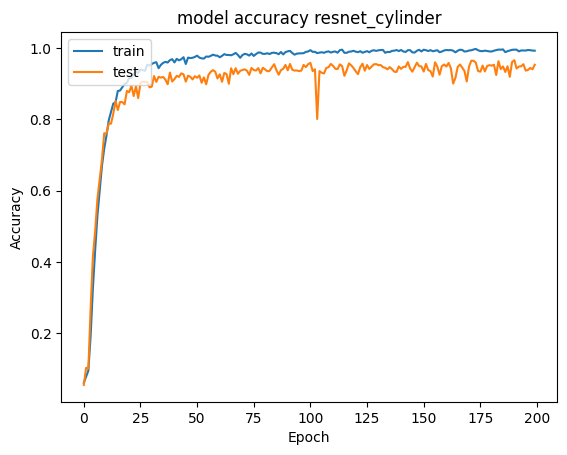

In [19]:
# non_norm_model = non_norm(len(range_fft_dict))

# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = [1, 32]
filter_out_list = [32, 64]
kernel_size = 3
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
history = train(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_cylinder', Epoch=200)

X shape :  (3264, 301, 1)
Model: "resnet_regression_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 resnet_layer_9 (ResnetLayer  multiple                 24484     
 )                                                               
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_36 (Dense)            multiple                  2465920   
                                                                 
 dense_37 (Dense)            multiple                  8256      
                                                                 
 dense_38 (Dense)    

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 44ms/step - loss: 2401.3000 - mae: 12.0921 - mse: 2401.3000 - val_loss: 15.8238 - val_mae: 3.2392 - val_mse: 15.8238
Epoch 2/500
101/102 [============================>.] - ETA: 0s - loss: 14.6274 - mae: 3.0670 - mse: 14.6274

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 14.5460 - mae: 3.0572 - mse: 14.5460 - val_loss: 14.5178 - val_mae: 3.0693 - val_mse: 14.5178
Epoch 3/500
102/102 [==============================] - 2s 15ms/step - loss: 19.7360 - mae: 3.5608 - mse: 19.7360 - val_loss: 19.1450 - val_mae: 3.6171 - val_mse: 19.1450
Epoch 4/500
102/102 [==============================] - ETA: 0s - loss: 13.9346 - mae: 2.9841 - mse: 13.9346

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 13.9346 - mae: 2.9841 - mse: 13.9346 - val_loss: 12.4459 - val_mae: 2.8901 - val_mse: 12.4459
Epoch 5/500
102/102 [==============================] - 2s 16ms/step - loss: 20.8219 - mae: 3.6790 - mse: 20.8219 - val_loss: 16.5947 - val_mae: 3.3989 - val_mse: 16.5947
Epoch 6/500
102/102 [==============================] - 2s 15ms/step - loss: 15.7487 - mae: 3.1919 - mse: 15.7487 - val_loss: 27.3781 - val_mae: 4.4048 - val_mse: 27.3781
Epoch 7/500
102/102 [==============================] - 2s 15ms/step - loss: 20.9155 - mae: 3.6465 - mse: 20.9155 - val_loss: 30.0095 - val_mae: 4.6575 - val_mse: 30.0095
Epoch 8/500
102/102 [==============================] - 2s 15ms/step - loss: 13.3131 - mae: 2.9068 - mse: 13.3131 - val_loss: 13.7295 - val_mae: 3.0526 - val_mse: 13.7295
Epoch 9/500
102/102 [==============================] - 2s 15ms/step - loss: 14.2284 - mae: 3.0169 - mse: 14.2284 - val_loss: 13.9482 - val_mae: 2.9976 - val_mse: 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 12.6945 - mae: 2.8490 - mse: 12.6945 - val_loss: 8.9177 - val_mae: 2.4114 - val_mse: 8.9177
Epoch 11/500
102/102 [==============================] - 2s 16ms/step - loss: 15.0984 - mae: 3.1006 - mse: 15.0984 - val_loss: 20.8991 - val_mae: 3.8295 - val_mse: 20.8991
Epoch 12/500
100/102 [============================>.] - ETA: 0s - loss: 12.0503 - mae: 2.7765 - mse: 12.0503

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 11.9842 - mae: 2.7678 - mse: 11.9842 - val_loss: 7.7669 - val_mae: 2.2147 - val_mse: 7.7669
Epoch 13/500
100/102 [============================>.] - ETA: 0s - loss: 12.7857 - mae: 2.8585 - mse: 12.7857

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 12.7118 - mae: 2.8511 - mse: 12.7118 - val_loss: 7.1334 - val_mae: 2.1387 - val_mse: 7.1334
Epoch 14/500
102/102 [==============================] - 2s 16ms/step - loss: 12.6922 - mae: 2.8788 - mse: 12.6922 - val_loss: 9.9306 - val_mae: 2.5714 - val_mse: 9.9306
Epoch 15/500
102/102 [==============================] - 2s 16ms/step - loss: 15.4454 - mae: 3.1421 - mse: 15.4454 - val_loss: 16.1398 - val_mae: 3.3188 - val_mse: 16.1398
Epoch 16/500
102/102 [==============================] - 2s 16ms/step - loss: 7.7016 - mae: 2.2122 - mse: 7.7016 - val_loss: 8.9553 - val_mae: 2.4690 - val_mse: 8.9553
Epoch 17/500
101/102 [============================>.] - ETA: 0s - loss: 7.6659 - mae: 2.1861 - mse: 7.6659

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 7.6857 - mae: 2.1883 - mse: 7.6857 - val_loss: 5.0222 - val_mae: 1.7685 - val_mse: 5.0222
Epoch 18/500
100/102 [============================>.] - ETA: 0s - loss: 5.4965 - mae: 1.8478 - mse: 5.4965

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.5225 - mae: 1.8507 - mse: 5.5225 - val_loss: 4.8343 - val_mae: 1.7480 - val_mse: 4.8343
Epoch 19/500
101/102 [============================>.] - ETA: 0s - loss: 7.0941 - mae: 2.1085 - mse: 7.0941

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 7.1015 - mae: 2.1081 - mse: 7.1015 - val_loss: 4.7884 - val_mae: 1.7508 - val_mse: 4.7884
Epoch 20/500
101/102 [============================>.] - ETA: 0s - loss: 6.9637 - mae: 2.0916 - mse: 6.9637

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 6.9354 - mae: 2.0877 - mse: 6.9354 - val_loss: 4.6044 - val_mae: 1.7194 - val_mse: 4.6044
Epoch 21/500
102/102 [==============================] - 2s 15ms/step - loss: 6.0443 - mae: 1.9518 - mse: 6.0443 - val_loss: 6.9587 - val_mae: 2.1764 - val_mse: 6.9587
Epoch 22/500
 98/102 [===========================>..] - ETA: 0s - loss: 6.0539 - mae: 1.9375 - mse: 6.0539

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.9889 - mae: 1.9294 - mse: 5.9889 - val_loss: 4.0048 - val_mae: 1.5618 - val_mse: 4.0048
Epoch 23/500
102/102 [==============================] - 1s 14ms/step - loss: 5.9573 - mae: 1.9441 - mse: 5.9573 - val_loss: 4.0735 - val_mae: 1.5957 - val_mse: 4.0735
Epoch 24/500
102/102 [==============================] - ETA: 0s - loss: 4.3689 - mae: 1.6432 - mse: 4.3689

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 4.3689 - mae: 1.6432 - mse: 4.3689 - val_loss: 3.8140 - val_mae: 1.5498 - val_mse: 3.8140
Epoch 25/500
102/102 [==============================] - ETA: 0s - loss: 5.1409 - mae: 1.7960 - mse: 5.1409

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.1409 - mae: 1.7960 - mse: 5.1409 - val_loss: 3.7635 - val_mae: 1.5171 - val_mse: 3.7635
Epoch 26/500
102/102 [==============================] - 2s 15ms/step - loss: 3.5220 - mae: 1.4718 - mse: 3.5220 - val_loss: 4.4010 - val_mae: 1.6169 - val_mse: 4.4010
Epoch 27/500
102/102 [==============================] - 2s 15ms/step - loss: 4.0959 - mae: 1.5994 - mse: 4.0959 - val_loss: 5.0757 - val_mae: 1.7706 - val_mse: 5.0757
Epoch 28/500
102/102 [==============================] - 2s 16ms/step - loss: 3.5920 - mae: 1.4807 - mse: 3.5920 - val_loss: 4.2598 - val_mae: 1.6570 - val_mse: 4.2598
Epoch 29/500
102/102 [==============================] - 2s 15ms/step - loss: 3.3147 - mae: 1.4139 - mse: 3.3147 - val_loss: 3.8176 - val_mae: 1.5297 - val_mse: 3.8176
Epoch 30/500
102/102 [==============================] - 2s 15ms/step - loss: 2.9702 - mae: 1.3712 - mse: 2.9702 - val_loss: 5.2518 - val_mae: 1.7995 - val_mse: 5.2518
Epoch 31/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 3.1755 - mae: 1.4132 - mse: 3.1755 - val_loss: 2.8517 - val_mae: 1.3033 - val_mse: 2.8517
Epoch 32/500
102/102 [==============================] - 2s 15ms/step - loss: 4.2045 - mae: 1.6010 - mse: 4.2045 - val_loss: 3.3619 - val_mae: 1.4245 - val_mse: 3.3619
Epoch 33/500
102/102 [==============================] - 2s 15ms/step - loss: 26.6353 - mae: 2.2073 - mse: 26.6353 - val_loss: 52.5412 - val_mae: 6.1846 - val_mse: 52.5412
Epoch 34/500
102/102 [==============================] - 2s 15ms/step - loss: 16.3630 - mae: 3.1866 - mse: 16.3630 - val_loss: 7.4690 - val_mae: 2.2107 - val_mse: 7.4690
Epoch 35/500
102/102 [==============================] - 2s 15ms/step - loss: 7.1629 - mae: 2.1333 - mse: 7.1629 - val_loss: 5.9703 - val_mae: 1.9535 - val_mse: 5.9703
Epoch 36/500
102/102 [==============================] - 2s 15ms/step - loss: 5.6321 - mae: 1.8873 - mse: 5.6321 - val_loss: 5.5855 - val_mae: 1.8912 - val_mse: 5.5855
Epoch

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 2.3480 - mae: 1.1718 - mse: 2.3480 - val_loss: 2.7269 - val_mae: 1.2867 - val_mse: 2.7269
Epoch 47/500
102/102 [==============================] - 2s 16ms/step - loss: 2.4970 - mae: 1.2140 - mse: 2.4970 - val_loss: 2.7894 - val_mae: 1.3054 - val_mse: 2.7894
Epoch 48/500
102/102 [==============================] - 2s 16ms/step - loss: 1.8136 - mae: 1.0415 - mse: 1.8136 - val_loss: 2.7935 - val_mae: 1.3186 - val_mse: 2.7935
Epoch 49/500
100/102 [============================>.] - ETA: 0s - loss: 1.7052 - mae: 1.0098 - mse: 1.7052

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.7064 - mae: 1.0097 - mse: 1.7064 - val_loss: 2.5622 - val_mae: 1.2276 - val_mse: 2.5622
Epoch 50/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5787 - mae: 0.9696 - mse: 1.5787 - val_loss: 2.7976 - val_mae: 1.2829 - val_mse: 2.7976
Epoch 51/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5701 - mae: 0.9673 - mse: 1.5701 - val_loss: 3.6444 - val_mae: 1.5163 - val_mse: 3.6444
Epoch 52/500
100/102 [============================>.] - ETA: 0s - loss: 1.4416 - mae: 0.9162 - mse: 1.4416

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.4390 - mae: 0.9150 - mse: 1.4390 - val_loss: 2.3186 - val_mae: 1.1745 - val_mse: 2.3186
Epoch 53/500
100/102 [============================>.] - ETA: 0s - loss: 1.3655 - mae: 0.8975 - mse: 1.3655

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3667 - mae: 0.8983 - mse: 1.3667 - val_loss: 2.1679 - val_mae: 1.1323 - val_mse: 2.1679
Epoch 54/500
100/102 [============================>.] - ETA: 0s - loss: 1.3354 - mae: 0.8857 - mse: 1.3354

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3315 - mae: 0.8827 - mse: 1.3315 - val_loss: 2.0915 - val_mae: 1.1103 - val_mse: 2.0915
Epoch 55/500
102/102 [==============================] - ETA: 0s - loss: 1.2466 - mae: 0.8635 - mse: 1.2466

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 1.2466 - mae: 0.8635 - mse: 1.2466 - val_loss: 2.0906 - val_mae: 1.1227 - val_mse: 2.0906
Epoch 56/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1839 - mae: 0.8395 - mse: 1.1839 - val_loss: 2.0975 - val_mae: 1.0992 - val_mse: 2.0975
Epoch 57/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1663 - mae: 0.8272 - mse: 1.1663 - val_loss: 2.1728 - val_mae: 1.1209 - val_mse: 2.1728
Epoch 58/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0570 - mae: 0.7958 - mse: 1.0570

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 1.0597 - mae: 0.7978 - mse: 1.0597 - val_loss: 2.0608 - val_mae: 1.0786 - val_mse: 2.0608
Epoch 59/500
102/102 [==============================] - ETA: 0s - loss: 1.0617 - mae: 0.7927 - mse: 1.0617

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.0617 - mae: 0.7927 - mse: 1.0617 - val_loss: 1.9994 - val_mae: 1.0537 - val_mse: 1.9994
Epoch 60/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0775 - mae: 0.8073 - mse: 1.0775

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0783 - mae: 0.8048 - mse: 1.0783 - val_loss: 1.8571 - val_mae: 1.0353 - val_mse: 1.8571
Epoch 61/500
102/102 [==============================] - 2s 15ms/step - loss: 0.9244 - mae: 0.7421 - mse: 0.9244 - val_loss: 2.1956 - val_mae: 1.0946 - val_mse: 2.1956
Epoch 62/500
102/102 [==============================] - 2s 16ms/step - loss: 1.0096 - mae: 0.7771 - mse: 1.0096 - val_loss: 1.9496 - val_mae: 1.0115 - val_mse: 1.9496
Epoch 63/500
102/102 [==============================] - 2s 16ms/step - loss: 0.8798 - mae: 0.7230 - mse: 0.8798 - val_loss: 2.0643 - val_mae: 1.0614 - val_mse: 2.0643
Epoch 64/500
101/102 [============================>.] - ETA: 0s - loss: 1.0394 - mae: 0.7936 - mse: 1.0394

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0355 - mae: 0.7919 - mse: 1.0355 - val_loss: 1.7620 - val_mae: 0.9954 - val_mse: 1.7620
Epoch 65/500
102/102 [==============================] - 2s 16ms/step - loss: 0.7959 - mae: 0.6950 - mse: 0.7959 - val_loss: 1.7645 - val_mae: 0.9718 - val_mse: 1.7645
Epoch 66/500
102/102 [==============================] - 2s 15ms/step - loss: 0.7371 - mae: 0.6630 - mse: 0.7371 - val_loss: 1.9203 - val_mae: 1.0212 - val_mse: 1.9203
Epoch 67/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6738 - mae: 0.6340 - mse: 0.6738 - val_loss: 2.4361 - val_mae: 1.1748 - val_mse: 2.4361
Epoch 68/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6948 - mae: 0.6504 - mse: 0.6948 - val_loss: 1.9890 - val_mae: 1.0691 - val_mse: 1.9890
Epoch 69/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6613 - mae: 0.6334 - mse: 0.6613 - val_loss: 1.7711 - val_mae: 0.9445 - val_mse: 1.7711
Epoch 70/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.5873 - mae: 0.6016 - mse: 0.5873 - val_loss: 1.6692 - val_mae: 0.9076 - val_mse: 1.6692
Epoch 72/500
102/102 [==============================] - 2s 16ms/step - loss: 0.5919 - mae: 0.6010 - mse: 0.5919 - val_loss: 1.7299 - val_mae: 0.9568 - val_mse: 1.7299
Epoch 73/500
102/102 [==============================] - 2s 15ms/step - loss: 0.5886 - mae: 0.5914 - mse: 0.5886 - val_loss: 1.9116 - val_mae: 0.9903 - val_mse: 1.9116
Epoch 74/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8842 - mae: 0.7214 - mse: 0.8842 - val_loss: 1.9108 - val_mae: 0.9964 - val_mse: 1.9108
Epoch 75/500
 99/102 [============================>.] - ETA: 0s - loss: 0.8336 - mae: 0.7022 - mse: 0.8336

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 0.8333 - mae: 0.7012 - mse: 0.8333 - val_loss: 1.6159 - val_mae: 0.9169 - val_mse: 1.6159
Epoch 76/500
102/102 [==============================] - 2s 16ms/step - loss: 1.1816 - mae: 0.6743 - mse: 1.1816 - val_loss: 40.7677 - val_mae: 5.5069 - val_mse: 40.7677
Epoch 77/500
102/102 [==============================] - 2s 16ms/step - loss: 5.9906 - mae: 1.7720 - mse: 5.9906 - val_loss: 2.9087 - val_mae: 1.3010 - val_mse: 2.9087
Epoch 78/500
102/102 [==============================] - 2s 15ms/step - loss: 1.4412 - mae: 0.9344 - mse: 1.4412 - val_loss: 2.4674 - val_mae: 1.1493 - val_mse: 2.4674
Epoch 79/500
102/102 [==============================] - 2s 16ms/step - loss: 0.9602 - mae: 0.7657 - mse: 0.9602 - val_loss: 1.9764 - val_mae: 1.0591 - val_mse: 1.9764
Epoch 80/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8893 - mae: 0.7343 - mse: 0.8893 - val_loss: 3.2197 - val_mae: 1.4053 - val_mse: 3.2197
Epoch 81/

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.3521 - mae: 0.4658 - mse: 0.3521 - val_loss: 1.5476 - val_mae: 0.8887 - val_mse: 1.5476
Epoch 91/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3538 - mae: 0.4625 - mse: 0.3538 - val_loss: 1.6913 - val_mae: 0.9244 - val_mse: 1.6913
Epoch 92/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3257 - mae: 0.4453 - mse: 0.3257 - val_loss: 1.6662 - val_mae: 0.9235 - val_mse: 1.6662
Epoch 93/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2738 - mae: 0.4121 - mse: 0.2738 - val_loss: 1.6223 - val_mae: 0.8911 - val_mse: 1.6223
Epoch 94/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3095 - mae: 0.4347 - mse: 0.3095 - val_loss: 1.6591 - val_mae: 0.9007 - val_mse: 1.6591
Epoch 95/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2589 - mae: 0.3966 - mse: 0.2589 - val_loss: 1.6342 - val_mae: 0.9429 - val_mse: 1.6342
Epoch 96/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.2346 - mae: 0.3805 - mse: 0.2346 - val_loss: 1.4538 - val_mae: 0.8504 - val_mse: 1.4538
Epoch 97/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2443 - mae: 0.3851 - mse: 0.2443 - val_loss: 1.5887 - val_mae: 0.9225 - val_mse: 1.5887
Epoch 98/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2987 - mae: 0.4243 - mse: 0.2987 - val_loss: 1.7635 - val_mae: 0.9390 - val_mse: 1.7635
Epoch 99/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2681 - mae: 0.4074 - mse: 0.2681 - val_loss: 1.5148 - val_mae: 0.8814 - val_mse: 1.5148
Epoch 100/500
102/102 [==============================] - 2s 16ms/step - loss: 0.2506 - mae: 0.3946 - mse: 0.2506 - val_loss: 2.2511 - val_mae: 1.1555 - val_mse: 2.2511
Epoch 101/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3056 - mae: 0.4335 - mse: 0.3056 - val_loss: 1.5900 - val_mae: 0.8766 - val_mse: 1.5900
Epoch 102

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.2063 - mae: 0.3562 - mse: 0.2063 - val_loss: 1.4153 - val_mae: 0.8254 - val_mse: 1.4153
Epoch 115/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2116 - mae: 0.3539 - mse: 0.2116 - val_loss: 1.4323 - val_mae: 0.8305 - val_mse: 1.4323
Epoch 116/500
102/102 [==============================] - 1s 15ms/step - loss: 0.1794 - mae: 0.3293 - mse: 0.1794 - val_loss: 1.7712 - val_mae: 0.9259 - val_mse: 1.7712
Epoch 117/500
102/102 [==============================] - 1s 14ms/step - loss: 0.2000 - mae: 0.3515 - mse: 0.2000 - val_loss: 1.5928 - val_mae: 0.8922 - val_mse: 1.5928
Epoch 118/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1193 - mae: 0.2711 - mse: 0.1193 - val_loss: 1.5743 - val_mae: 0.8954 - val_mse: 1.5743
Epoch 119/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1577 - mae: 0.3078 - mse: 0.1577 - val_loss: 1.5170 - val_mae: 0.8411 - val_mse: 1.5170
Epoch 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 0.1364 - mae: 0.2925 - mse: 0.1364 - val_loss: 1.3583 - val_mae: 0.8101 - val_mse: 1.3583
Epoch 128/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0998 - mae: 0.2478 - mse: 0.0998 - val_loss: 1.3738 - val_mae: 0.8034 - val_mse: 1.3738
Epoch 129/500
 99/102 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.2330 - mse: 0.0893

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 45ms/step - loss: 0.0892 - mae: 0.2329 - mse: 0.0892 - val_loss: 1.3357 - val_mae: 0.8181 - val_mse: 1.3357
Epoch 130/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1050 - mae: 0.2560 - mse: 0.1050 - val_loss: 1.3729 - val_mae: 0.8145 - val_mse: 1.3729
Epoch 131/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0871 - mae: 0.2290 - mse: 0.0871 - val_loss: 1.4004 - val_mae: 0.8370 - val_mse: 1.4004
Epoch 132/500
100/102 [============================>.] - ETA: 0s - loss: 0.1009 - mae: 0.2522 - mse: 0.1009

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.1008 - mae: 0.2523 - mse: 0.1008 - val_loss: 1.3289 - val_mae: 0.8015 - val_mse: 1.3289
Epoch 133/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1040 - mae: 0.2531 - mse: 0.1040 - val_loss: 1.4490 - val_mae: 0.8293 - val_mse: 1.4490
Epoch 134/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0759 - mae: 0.2165 - mse: 0.0759 - val_loss: 1.3897 - val_mae: 0.8101 - val_mse: 1.3897
Epoch 135/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1438 - mae: 0.2855 - mse: 0.1438 - val_loss: 1.5011 - val_mae: 0.8399 - val_mse: 1.5011
Epoch 136/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6515 - mae: 0.5240 - mse: 0.6515 - val_loss: 5.0691 - val_mae: 1.7616 - val_mse: 5.0691
Epoch 137/500
102/102 [==============================] - 2s 15ms/step - loss: 1562.7550 - mae: 20.0757 - mse: 1562.7550 - val_loss: 21.8882 - val_mae: 3.9101 - val_mse: 21.88

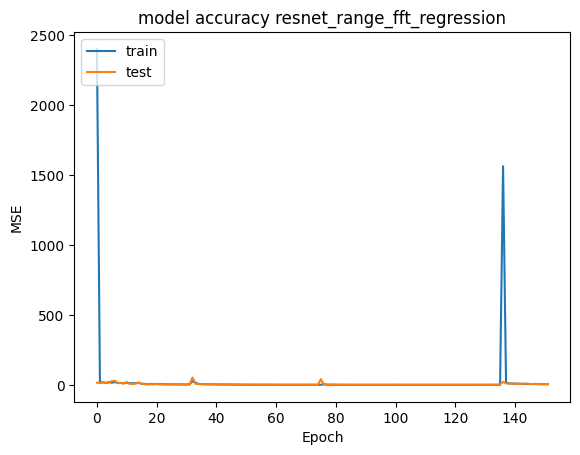

In [38]:
loss = tf.keras.losses.MeanSquaredError()
metrics = ['mae', 'mse']
model = Resnet_regression(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(range_fft_dict))
# reg_Y_train, reg_Y_test = np.argmax(Y_train, axis = 1), np.argmax(Y_test, axis = 1)
history = train_regression(model = model, X = X_train, Y = np.argmax(Y_train, axis=1), test_X = X_test, test_Y = np.argmax(Y_test, axis=1), cp_path = 'resnet_range_fft_regression', Epoch=500, loss = loss, metrics = metrics, monitor='val_mse', mode='min')

In [29]:
reshaped_data['00'][0].shape

(301,)

In [37]:
import time

In [40]:
reshaped_data['00'][0]
model = tf.keras.models.load_model('./model/resnet_min_max_cylinder')
for i in reshaped_data:
    time.sleep(10)
    cur_data = reshaped_data[i][0]
    cur_data = np.expand_dims(np.expand_dims(cur_data, axis = 1), axis = 0)

    json_data = json.dumps(cur_data.tolist())
    AE_ID = 'PackageInspection'
    RI = 'PackageInspection'
    URI = '/Mobius/PackageInspection/radarSensor/rawData'
    mobius_post(URI, AE_ID, RI, json_data)

    data = mobius_get(URI, AE_ID, RI)

    data = json.loads(data)['m2m:cin']['con']
    prd = model.predict(data)
    URI = '/Mobius/PackageInspection/report/objectCounting'

    y_label = np.argmax(prd, axis = 1)
    print(str(y_label[0]))

    dict = {
        "inputSource":"/Mobius/PersonalInspection/radarSensor/rawData",
        "modelName": "objectCounting",
        "modelVer":"1",
        "detection":{"count": str(y_label[0])}
    }

    pred = json.dumps(dict)

    mobius_post(URI, AE_ID, RI, pred)


{'Accept': 'application/json', 'X-M2M-RI': 'PackageInspection', 'X-M2M-Origin': 'PackageInspection', 'Content-Type': 'application/vnd.onem2m-res+json ; ty = 4'}
{"m2m:cin":{"rn":"4-20231010140522096","ty":4,"pi":"3-20231010132556855034","ri":"4-20231010140522097095","ct":"20231010T140522","lt":"20231010T140522","st":3,"et":"20251010T140522","cs":6418,"con":[[[0.4251675102984902],[0],[0.751924843908164],[0.5201594400092121],[0.32330787282633566],[0.20529880768581435],[0.4183378625717494],[0.5207005279988378],[0.2014899702392957],[0.18647559111076495],[0.44594399786828953],[0.4884825899367612],[0.3763330436342842],[0.6137651464802861],[0.3825768936342157],[0.3573782955736048],[0.7461862862873545],[0.3032059142858376],[0.1669725644632471],[0.1603885786761931],[0.6097660264639718],[0.5048787492196902],[0.38980930487468085],[0.3078279747364237],[0.22464428011761942],[0.20825457571877984],[0.43649388662294364],[0.3341607950891151],[0.3394149076705227],[0.608697601167987],[0.45042024138597164